In [350]:
import pandas as pd
import os, sys
from collections import defaultdict
import numpy as np
from sklearn.svm import LinearSVC
from sklearn import preprocessing

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [415]:
network = pd.read_csv('../data/network/vertex_attributes.csv')

network.shape

(1646, 16)

### Load Vertex Properties

In [418]:
cols = [u'name', u'degree',  u'in', u'out', u'core', u'core-in', u'core-out', u'closeness', u'betweenness', u'eigen_centrality', u'pagerank', u'neighborhood', u'avg_neighborhood', u'authority', u'hub', u'clustering_coef']
network = network[cols]
network['name'] = network['name'].astype(str)
network['percent-out'] = network['out'].div(network['degree'])
# # network['name'] = [col.split('@')[0] for col in network['name']]
# network.head()

### Global Network Measures

In [ ]:
VERTICES: 1646 
EDGES: 4924
GLOBAL CC 0.0418348603048
AVG PATH LENGTH 2.74013916003
CLIQUES 138340
CLIQUE NO 14
DIAMETER 22.0
RECIPROCITY 0.245735174655
LARGEST CLUSTER SIZE 378 Vertices, 2708 Edges

ONLY ASKED QUETIONS: 464
ONLY ANSWER ANSWERED: 764
ASKED AND ANSWER: 415

In [423]:
cols = [u'name', u'degree',  u'in', u'out', u'core', u'core-in', u'core-out', u'closeness', u'betweenness', u'eigen_centrality', u'pagerank', u'neighborhood', u'avg_neighborhood', u'authority', u'hub', u'clustering_coef']
network = network[cols]
network.apply(pd.to_numeric, errors='ignore')
print network.describe().round(4).loc[['mean', 'std', 'min', 'max']].T

                       mean         std     min          max
degree               5.9830     30.6500  0.0000     895.0000
in                   2.9915     15.3362  0.0000     417.0000
out                  2.9915     15.7134  0.0000     478.0000
core                 3.1422      3.9024  0.0000      23.0000
core-in              1.3621      2.1560  0.0000      12.0000
core-out             1.4216      1.9871  0.0000      10.0000
closeness            0.0492      0.0054  0.0006       0.0537
betweenness       1349.3092  12844.0691  0.0000  383864.1714
eigen_centrality     0.0050      0.0368  0.0000       1.0000
pagerank             0.0006      0.0043  0.0002       0.1336
neighborhood         6.2479     24.9207  1.0000     727.0000
avg_neighborhood  1431.9329   1726.0096  1.0000    5802.0000
authority            0.0029      0.0291  0.0000       1.0000
hub                  0.0070      0.0421  0.0000       1.0000
clustering_coef      0.9397      0.6718  0.0000       2.0000


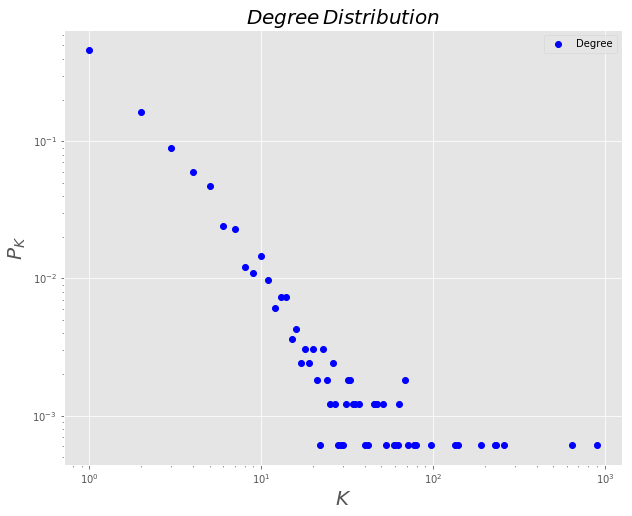

In [412]:
plotDegreeDistribution(network['degree'])

In [421]:
only_in = network['in'] > 0
no_out = network['out'] == 0

only_out = network['out'] > 0
no_in = network['in'] == 0

ask = network['in'] > 0
answer = network['out'] > 0

only_ask = network[(only_in & no_out)]
only_answer = network[(only_out & no_in)]
ask_answer = network[(ask & answer)]

print "ONLY ASK:", only_ask.shape[0]
print "ONLY ANSWER:", only_answer.shape[0]
print "ASK AND ANSWER:", ask_answer.shape[0]

ONLY ASK: 464
ONLY ANSWER: 764
ASK AND ANSWER: 415


In [425]:
ask_answer.describe()

,degree,in,out,core,core-in,core-out,closeness,betweenness,eigen_centrality,pagerank,neighborhood,avg_neighborhood,authority,hub,clustering_coef,percent-out
count,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000
mean,18.110843,9.238554,8.872289,7.431325,3.484337,3.354217,0.050956,5351.717970,0.017010,0.001701,16.195181,937.129489,0.010303,0.023831,0.789293,0.477846
std,59.363103,29.571145,30.423668,5.586343,3.010308,2.780596,0.001940,25179.866616,0.071883,0.008415,48.202000,967.328948,0.057416,0.081260,0.500671,0.191391
min,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.039743,0.000000,0.000000,0.000179,2.000000,5.153846,0.000000,0.000000,0.000000,0.071429
25%,4.000000,2.000000,1.000000,3.000000,1.000000,1.000000,0.050702,126.127228,0.001513,0.000264,4.000000,328.008257,0.000558,0.000780,0.462500,0.333333
50%,7.000000,3.000000,3.000000,6.000000,2.000000,2.000000,0.051398,1184.741333,0.003494,0.000463,7.000000,621.000000,0.001644,0.004525,0.682540,0.500000
75%,14.000000,7.000000,7.000000,10.000000,5.000000,5.000000,0.051994,3774.431202,0.008662,0.000920,13.000000,1209.583333,0.004410,0.015133,1.000000,0.600000
max,895.000000,417.000000,478.000000,23.000000,12.000000,10.000000,0.053660,383864.171442,1.000000,0.133625,727.000000,5802.000000,1.000000,1.000000,2.000000,0.928571


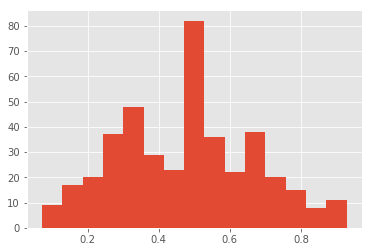

In [422]:
ask_answer['percent-out'].hist(bins=15)

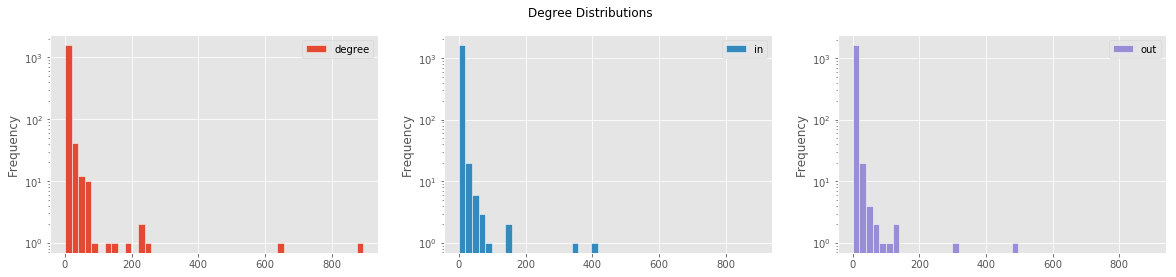

In [424]:
title = 'Degree Distributions'
degrees = network[['degree', 'in', 'out']]
degrees.plot(kind='hist', subplots=True, layout=(1,3), title=title, log=True, figsize=(20, 4), bins=45, edgecolor='w')
# plt.plot()
plt.show()

### Add column for whether or not user is in the organizers group

In [363]:
edges = pd.read_csv('../data/network/plots_edgelist.csv')
plots_org = edges[edges['fid'] == 'plots-organizers']
organizers = pd.concat([plots_org['source'], plots_org['target']])
network['org'] = network['name'].isin(organizers)
# network.head()

### Filter out those who have only answered or only asked a question

In [364]:
ask = network['in'] > 0
answer = network['out'] > 0
ask_answer = network[(ask & answer)]
ask_answer.shape

(415, 18)

### Filter out "active" users

In [365]:
print pd.DataFrame([ask_answer['degree'].describe(), ask_answer['in'].describe(), ask_answer['out'].describe()]).T
ask_answer[ask_answer['degree'] >= 7].shape, ask_answer[ask_answer['in'] >= 7].shape, ask_answer[ask_answer['out'] >= 7].shape

           degree          in         out
count  415.000000  415.000000  415.000000
mean    18.110843    9.238554    8.872289
std     59.363103   29.571145   30.423668
min      2.000000    1.000000    1.000000
25%      4.000000    2.000000    1.000000
50%      7.000000    3.000000    3.000000
75%     14.000000    7.000000    7.000000
max    895.000000  417.000000  478.000000


((219, 18), (118, 18), (117, 18))

In [366]:
include_in = ask_answer['in'] >= 3
include_out = ask_answer['out'] >= 3

active = ask_answer[(include_in | include_out)]
active.shape

(304, 18)

### Label users as primaraly "question askers", "question answerers", or "both"

In [367]:
active['percent-out'].describe(percentiles=[.33, .5, .66])

count    304.000000
mean       0.472499
std        0.212378
min        0.071429
33%        0.351912
50%        0.467343
66%        0.562450
max        0.928571
Name: percent-out, dtype: float64

In [369]:
active['ans'] = active['percent-out'] > .56
active['ask'] = active['percent-out'] < .35
active['both'] = (active['ans'] == False) & (active['ask'] == False)

### Sepperate features and labels

In [287]:
feature_cols = active.columns[1:-4]
labels_cols = active.columns[-4:]

features = active[feature_cols]
labels = active[labels_cols]
print features.shape, labels.shape

(304, 16) (304, 4)


### Normalize the data

In [300]:
min_max_scaler = preprocessing.MinMaxScaler()
feat_scaled = min_max_scaler.fit_transform(features)
feat_norm = pd.DataFrame(feat_scaled, columns=features.columns)
# feat_norm.head()

### LinearSVC for Question Askers

In [327]:
ask_clf = LinearSVC(random_state=0)
ask_clf.fit(feat_norm, labels['ask'])

coef = ask_clf.coef_.ravel()

importance = pd.DataFrame(coef, index=feat_norm.columns, columns=['value'])#, columns=features.columns)

pos_class = importance[importance['value'] > 0]
neg_class = importance[importance['value'] < 0]

print 'ACCURACY:', ask_clf.score(feat_norm, labels['ask'])
print ''
print pos_class.sort_values(by='value', ascending=False)
print ''
print neg_class.sort_values(by='value', ascending=True)

ACCURACY: 0.990131578947

                     value
closeness         0.889937
core              0.538549
core-in           0.509686
avg_neighborhood  0.347944

                     value
percent-out      -5.733127
core-out         -1.152479
out              -0.339523
clustering_coef  -0.328290
neighborhood     -0.272319
degree           -0.269900
hub              -0.239677
authority        -0.227476
eigen_centrality -0.206277
in               -0.182784
pagerank         -0.171987
betweenness      -0.046530


In [432]:
ask_cols = ['closeness', 'core', 'core-in','avg_neighborhood']

ask = active[active['ask'] == True]
ask = ask[ask_cols]

not_ask = active[active['ask'] == False]
not_ask = not_ask[ask_cols]

ask_total = active[ask_cols]

print 'QUESTION ASKERS'
ask['avg_neighborhood'] = normalize_column(ask['avg_neighborhood'])
print ask.describe().round(4).loc[['mean', 'std', 'min', 'max']]
print ''
print 'NOT QUESTION ASKERS'
not_ask['avg_neighborhood'] = normalize_column(not_ask['avg_neighborhood'])
print not_ask.describe().round(4).loc[['mean', 'std', 'min', 'max']]
print ''
print 'ORIGINALS'
ask_total['avg_neighborhood'] = normalize_column(ask_total['avg_neighborhood'])
print ask_total.describe().round(4).loc[['mean', 'std', 'min', 'max']]

QUESTION ASKERS
      closeness     core  core-in  avg_neighborhood
mean     0.0513   7.4949   4.5657           27.9417
std      0.0015   4.6431   2.5760           22.6952
min      0.0431   2.0000   1.0000            0.0000
max      0.0531  21.0000  12.0000          100.0000

NOT QUESTION ASKERS
      closeness     core  core-in  avg_neighborhood
mean     0.0511   9.9902   4.2000           21.5235
std      0.0021   5.8040   3.3364           16.9184
min      0.0413   3.0000   0.0000            0.0000
max      0.0537  23.0000  12.0000          100.0000

ORIGINALS
      closeness     core  core-in  avg_neighborhood
mean     0.0512   9.1776   4.3191           21.2857
std      0.0019   5.5700   3.1097           17.9683
min      0.0413   2.0000   0.0000            0.0000
max      0.0537  23.0000  12.0000          100.0000


/home/skilfullycurled/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### LinearSVC for Question Answerers

In [325]:
ans_clf = LinearSVC(random_state=0)
ans_clf.fit(feat_norm, labels['ans'])
coef = ans_clf.coef_.ravel()

importance = pd.DataFrame(coef, index=feat_norm.columns, columns=['value'])#, columns=features.columns)

pos_class = importance[importance['value'] > 0]
neg_class = importance[importance['value'] < 0]


print 'ACCURACY:', ans_clf.score(feat_norm, labels['ans'])
print ''
print pos_class.sort_values(by='value', ascending=False)
print ''
print neg_class.sort_values(by='value', ascending=True)

ACCURACY: 0.983552631579

                     value
percent-out       4.975779
core-out          0.728077
avg_neighborhood  0.519589
hub               0.517840
out               0.462426
betweenness       0.367190
core              0.363058
neighborhood      0.224072
degree            0.127965

                     value
core-in          -1.798889
pagerank         -0.499532
eigen_centrality -0.409230
clustering_coef  -0.346752
authority        -0.316502
in               -0.268493
closeness        -0.169403


In [435]:
ans_cols = ['percent-out', 'core-out', 'avg_neighborhood', 'hub', 'out', 'betweenness', 'core', 'neighborhood', 'degree']

ans = active[active['ans'] == True]
ans = ans[ans_cols]
ans.columns = ['pct-out', 'core-out', 'avg_ngh', 'hub', 'out', 'btwn', 'core', 'ngh', 'deg']

not_ans = active[active['ans'] == False]
not_ans = not_ans[ans_cols]
not_ans.columns = ['pct-out', 'core-out', 'avg_ngh', 'hub', 'out', 'btwn', 'core', 'ngh', 'deg']

ans_total = active[ans_cols]
ans_total.columns = ['pct-out', 'core-out', 'avg_ngh', 'hub', 'out', 'btwn', 'core', 'ngh', 'deg']



print 'QUESTION ANSWERERS'
ans['btwn'] = normalize_column(ans['btwn'])
print ans.describe().round(4).loc[['mean', 'std', 'min', 'max']]
print ''
print 'NOT QUESTION ANSWERERS'
not_ans['btwn'] = normalize_column(not_ans['btwn'])
print not_ans.describe().round(4).loc[['mean', 'std', 'min', 'max']]
print ''
print 'ORIGINALS'
ans_total['btwn'] = normalize_column(ans_total['btwn'])
print ans_total.describe().round(4).loc[['mean', 'std', 'min', 'max']]

QUESTION ANSWERERS
      pct-out  core-out    avg_ngh     hub       out      btwn     core  \
mean   0.7108    4.9712   627.5113  0.0298   11.6923    5.3388   8.6442   
std    0.1077    2.4114   444.1074  0.0751   18.7099   12.7567   4.6840   
min    0.5625    1.0000    12.1667  0.0000    3.0000    0.0000   3.0000   
max    0.9286   10.0000  2543.6667  0.6239  137.0000  100.0000  23.0000   

           ngh       deg  
mean   15.8558   17.1346  
std    25.2838   29.6589  
min     4.0000    4.0000  
max   197.0000  229.0000  

NOT QUESTION ANSWERERS
      pct-out  core-out    avg_ngh     hub       out      btwn     core  \
mean   0.3486    3.7250   664.9196  0.0325   11.5750    2.1301   9.4550   
std    0.1326    2.9535   592.9393  0.1023   41.2472    9.1104   5.9713   
min    0.0714    0.0000     5.1538  0.0000    1.0000    0.0000   2.0000   
max    0.5600   10.0000  3044.6000  1.0000  478.0000  100.0000  23.0000   

           ngh       deg  
mean   23.4650   27.1350  
std    66.0165  

/home/skilfullycurled/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### LinearSVC for both

In [323]:
both_clf = LinearSVC(random_state=0)
both_clf.fit(feat_norm, labels['both'])

coef = both_clf.coef_.ravel()

importance = pd.DataFrame(coef, index=feat_norm.columns, columns=['value'])#, columns=features.columns)

pos_class = importance[importance['value'] > 0]
neg_class = importance[importance['value'] < 0]

print 'ACCURACY:', both_clf.score(feat_norm, labels['both'])
print ''
print pos_class.sort_values(by='value', ascending=False)
print ''
print neg_class.sort_values(by='value', ascending=True)

ACCURACY: 0.730263157895

                     value
core-in           1.357760
core-out          1.206679
eigen_centrality  0.883126
pagerank          0.609240
authority         0.468953
in                0.297901

                     value
core             -1.258739
closeness        -1.027146
betweenness      -0.676938
out              -0.435626
neighborhood     -0.297430
percent-out      -0.163047
avg_neighborhood -0.161614
clustering_coef  -0.096385
degree           -0.094268
hub              -0.079516


In [408]:
both_cols = ['core-in', 'core-out', 'eigen_centrality', 'pagerank', 'authority', 'in']

both = active[active['both'] == True]
both = both[both_cols]
both.columns = ['core-in', 'core-out', 'eigen_cent', 'pagerank', 'authority', 'in']

not_both = active[active['both'] == False]
not_both = not_both[both_cols]
not_both.columns = ['core-in', 'core-out', 'eigen_cent', 'pagerank', 'authority', 'in']


both_total = active[both_cols]
both_total.columns = ['core-in', 'core-out', 'eigen_cent', 'pagerank', 'authority', 'in']

print 'BOTH'
print both.describe().round(4).loc[['mean', 'std', 'min', 'max']]
print ''
print 'NOT BOTH'
print not_both.describe().round(4).loc[['mean', 'std', 'min', 'max']]
print ''
print 'ORIGINALS'
print both_total.describe().round(4).loc[['mean', 'std', 'min', 'max']]

BOTH
      core-in  core-out  eigen_cent  pagerank  authority        in
mean   5.6436    5.1980      0.0467    0.0048     0.0304   22.0891
std    3.5315    3.0134      0.1385    0.0166     0.1132   56.3472
min    1.0000    1.0000      0.0000    0.0002     0.0000    3.0000
max   12.0000   10.0000      1.0000    0.1336     1.0000  417.0000

NOT BOTH
      core-in  core-out  eigen_cent  pagerank  authority       in
mean   3.6601    3.6305      0.0104    0.0010     0.0054   7.1281
std    2.6491    2.6017      0.0219    0.0016     0.0118   9.9759
min    0.0000    0.0000      0.0000    0.0002     0.0000   1.0000
max   12.0000   10.0000      0.1733    0.0143     0.1055  92.0000

ORIGINALS
      core-in  core-out  eigen_cent  pagerank  authority        in
mean   4.3191    4.1513      0.0225    0.0022     0.0137   12.0987
std    3.1097    2.8384      0.0833    0.0098     0.0668   34.1178
min    0.0000    0.0000      0.0000    0.0002     0.0000    1.0000
max   12.0000   10.0000      1.0000    0.

### LinearSVC for Organizers Group

In [312]:
org_clf = LinearSVC(random_state=0)
org_clf.fit(feat_norm, labels['org'])

coef = org_clf.coef_.ravel()

importance = pd.DataFrame(coef, index=ask_vs_ans_features.columns, columns=['value'])#, columns=features.columns)

pos_class = importance[importance['value'] > 0]
neg_class = importance[importance['value'] < 0]

print 'ACCURACY:', org_clf.score(feat_norm, labels['org'])
print ''
print pos_class.sort_values(by='value', ascending=False)
print ''
print neg_class.sort_values(by='value', ascending=True)

ACCURACY: 0.845394736842

                    value
core-out         1.317718
clustering_coef  0.998933
closeness        0.866951
core             0.841655
hub              0.351722
core-in          0.328157
betweenness      0.095578
authority        0.014014
pagerank         0.002447

                     value
avg_neighborhood -0.477735
percent-out      -0.388952
in               -0.168667
neighborhood     -0.126438
degree           -0.098358
out              -0.045389
eigen_centrality -0.000859


In [436]:
org_cols = ['core-out', 'clustering_coef', 'closeness', 'core', 'hub', 'core-in', 'betweenness']

org = active[active['org'] == True]
org = org[org_cols]
org.columns = ['core-out', 'clust_coef', 'closeness', 'core', 'hub', 'core-in', 'betweenness']

not_org = active[active['org'] == False]
not_org = not_org[org_cols]
not_org.columns = ['core-out', 'clust_coef', 'closeness', 'core', 'hub', 'core-in', 'betweenness']

org_total = active[org_cols]
org_total.columns = ['core-out', 'clust_coef', 'closeness', 'core', 'hub', 'core-in', 'betweenness']

print 'ORGANIZERS'
org['betweenness'] = normalize_column(org['betweenness'])
print org.describe().round(4).loc[['mean', 'std', 'min', 'max']]
print ''
print 'NOT ORGANIZERS'
not_org['betweenness'] = normalize_column(not_org['betweenness'])
print not_org.describe().round(4).loc[['mean', 'std', 'min', 'max']]
print ''
print 'ORIGINALS'
org_total['betweenness'] = normalize_column(org_total['betweenness'])
print org_total.describe().round(4).loc[['mean', 'std', 'min', 'max']]

ORGANIZERS
      core-out  clust_coef  closeness     core     hub  core-in  betweenness
mean    6.6250      0.7379     0.0520  14.2019  0.0741   6.7308       4.2500
std     2.7348      0.3310     0.0006   5.8449  0.1504   3.6075      12.6706
min     1.0000      0.0923     0.0501   4.0000  0.0000   1.0000       0.0000
max    10.0000      1.8333     0.0537  23.0000  1.0000  12.0000     100.0000

NOT ORGANIZERS
      core-out  clust_coef  closeness     core     hub  core-in  betweenness
mean     2.865      0.7028     0.0508   6.5650  0.0094   3.0650      12.6873
std      1.880      0.3307     0.0023   3.0827  0.0154   1.8351      16.6197
min      0.000      0.0000     0.0413   2.0000  0.0000   0.0000       0.0000
max     10.000      1.8182     0.0530  19.0000  0.0928  11.0000     100.0000

ORIGINALS
      core-out  clust_coef  closeness     core     hub  core-in  betweenness
mean    4.1513      0.7149     0.0512   9.1776  0.0315   4.3191       1.8491
std     2.8384      0.3307     0.0019 

/home/skilfullycurled/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [411]:
#http://www.pythonexample.com/code/plot-degree-distribution-igraph-python/

def plotDegreeDistribution(degrees):
    degs = defaultdict(int)
    for i in degrees: 
        degs[i]+=1
    items = sorted ( degs.items () )
    x, y = np.array(items).T
    y = [float(i) / sum(y) for i in y]
    plt.figure(figsize=(10,8))
    plt.plot(x, y, 'bo')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(['Degree'])
    plt.xlabel('$K$', fontsize = 20)
    plt.ylabel('$P_K$', fontsize = 20)
    plt.title('$Degree\,Distribution$', fontsize = 20)
    plt.show()

In [430]:
def normalize_column(col):
    result = col.copy()
    
    max_value = col.max()
    min_value = col.min()
    
    result = ( (col - min_value) / (max_value - min_value) ) * 100
    
    return result 